In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def lin_scale(array, sz_min, sz_max):
    """Scale a numpy array to span from sz_min to sz_max."""
    scale_diff = sz_max - sz_min
    lst_diff = max(array) - min(array)
    m = np.divide(scale_diff, lst_diff)
    b = np.divide(sz_min * max(array) - sz_max * min(array), lst_diff)
    
    return m * array + b

In [3]:
#data_url = 'http://www.ndbc.noaa.gov/data/5day2/46022_5day.txt'
#data_url = 'http://www.ndbc.noaa.gov/data/realtime2/46022.txt'
data_url = 'http://www.ndbc.noaa.gov/data/realtime2/46244.txt'

# Set the number of hours to report.
parse = lambda x: pd.to_datetime(x, format='%Y %m %d %H %M')
MWD = pd.read_csv(
    data_url, 
    header=0, 
    skiprows=[1], 
    nrows=24, 
    sep='\s+', 
    na_values=['MM', -99], 
    usecols=['#YY', 'MM', 'DD', 'hh', 'mm', 'WVHT', 'DPD', 'MWD'],
    parse_dates={'Date':['#YY', 'MM', 'DD', 'hh', 'mm']}, 
    date_parser=parse, 
    index_col=0,
)

# The data is reported in 'UTC'. Change local_time to desired time zone.
local_time = 'US/Pacific'
MWD = MWD.tz_localize('UTC')
MWD = MWD.tz_convert(local_time)
MWD.reset_index(inplace=True)

# Convert meters to feet.
MWD['WVHT'] = MWD['WVHT'].apply(lambda x: np.around(x * 3.4, decimals=1))
print(MWD.columns)

Index(['Date', 'WVHT', 'DPD', 'MWD'], dtype='object')


In [4]:
MWD.describe()

,WVHT,DPD,MWD
count,24.000000,24.000000,24.000000
mean,7.158333,8.666667,323.416667
std,0.812894,0.637022,5.640819
min,6.500000,7.000000,311.000000
25%,6.500000,8.000000,320.500000
50%,6.800000,9.000000,323.500000
75%,7.575000,9.000000,329.000000
max,8.800000,10.000000,330.000000


In [5]:
# Get info for title string
height_min = str(float(MWD[['WVHT']].min().values)) + '\''
height_max = str(float(MWD[['WVHT']].max().values)) + '\''
hts_str = height_min + ' to ' + height_max

# Get most current time reported
latest_data = MWD.iloc[[MWD['Date'].idxmax()]]
date_str = latest_data['Date'][0].ctime()
tlt_str = ('Buoy ' 
           + data_url[-9:-4] 
           + ' Last 24 Reports ' 
           + '\n' + date_str 
           + '\n Hts ' + hts_str
           )
# Get most current data
latest_wht = str(float(latest_data['WVHT'].values))
latest_dpd = str(float(latest_data['DPD'].values))
latest_mwd = str(float(latest_data['MWD'].values))
latest_str = (date_str 
              + '\n' + latest_wht + ' ft @ ' + latest_dpd + ' sec' 
              + '\n' + 'Direction: ' + latest_mwd
              ) 

print(latest_str)

Mon May 15 16:21:00 2017
6.8 ft @ 8.0 sec
Direction: 318.0


In [6]:
type(latest_data[['Date']].values)
latest_data['Date'][0].ctime()

'Mon May 15 16:21:00 2017'

In [7]:
# Create dataframe for plotting from.
plot_df = pd.DataFrame()

# x will be mean wave direction (theta).
plot_df['x'] = np.deg2rad(MWD['MWD'].copy())

# y cordinates start at 2 so that MWD can be detected (r).
plot_df['y'] = MWD.index + 2

# Scale point sizes between 20 and 200 based on max and min wave height (s).
plot_df['s'] = lin_scale(MWD['WVHT'], 20, 200)
#plot_df['s'] = lin_scale(MWD['DPD'], 20, 200)

# Show period using color scale (c).
plot_df['c'] = MWD['DPD']
#plot_df['c'] = MWD['WVHT']
plot_df.head()

,x,y,s,c
0,5.550147,2,43.478261,8
1,5.427974,3,20.000000,8
2,5.445427,4,20.000000,8
3,5.567600,5,43.478261,9
4,5.689773,6,20.000000,9


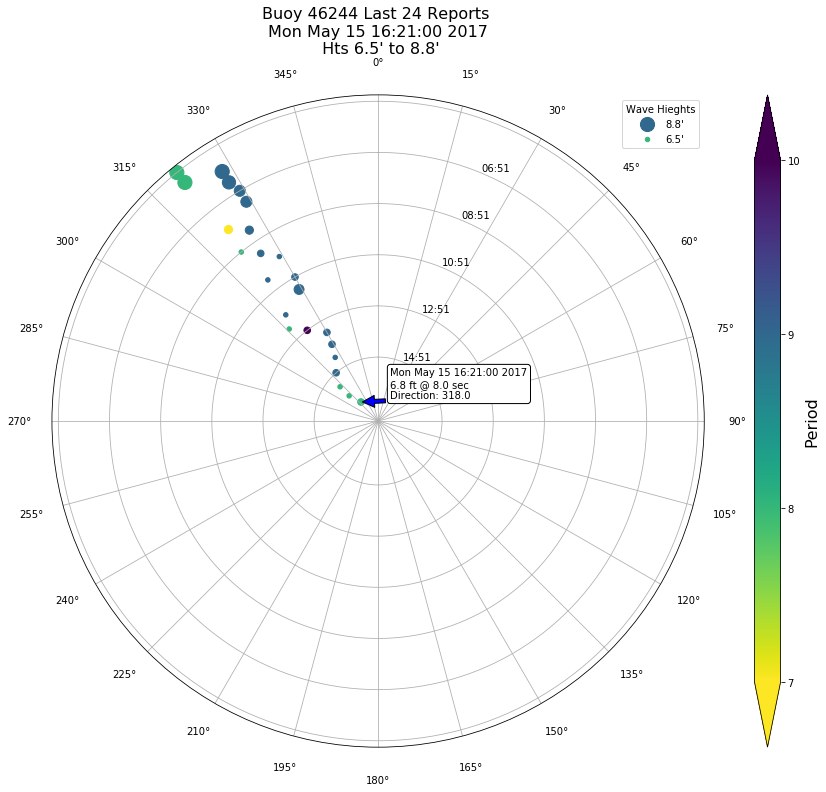

In [8]:
#Set up axis
#plt.rcParams['figure.figsize'] =[18, 12]
plt.rcParams.update({'figure.figsize' : [18, 12], 'image.cmap' : 'viridis_r'})

ax = plt.subplot(projection='polar')
ax.set_theta_direction(-1)
ax.set_theta_offset(np.pi/2)
ax.set_rlim([0, 25.5])
ax.grid(True)

# Set up axis lables.
theta_tics = np.arange(0, 360, 15)
r_tics = np.arange( 5, 28, 4)
tic_lables = [str(tdate.time())[:-3] for tdate in MWD['Date'].iloc[3:21:4]]

ax.set_thetagrids(theta_tics)
ax.set_rgrids(r_tics)
ax.yaxis.set_ticklabels(tic_lables)

# Annotation for latest data.
anno_idx = plot_df['y'].idxmin()
theta = plot_df['x'][anno_idx]
r = plot_df['y'][anno_idx]
ax.annotate(latest_str,
            xy=(theta, r),
            xytext=(0.5, 2),    # fraction, fraction
            bbox=dict(boxstyle="round", fc="w"),
            arrowprops=dict(facecolor='blue', shrink=0.05),
            )

# Plot the data.
sc = ax.scatter(**plot_df, edgecolors='face', label=None)

# Create scatter objects for the legend of largest and smallest waves.
big = plot_df.iloc[plot_df.s.idxmax()]
ax.scatter([], [], s=big.s, c=sc.to_rgba(big.c), label=height_max)

small = plot_df.iloc[plot_df.s.idxmin()]
ax.scatter([], [], s=small.s, c=sc.to_rgba(small.c), label=height_min)

# Plot legend.
plt.legend(#loc="upper right", 
           scatterpoints=1, fontsize=10, title='Wave Hieghts',)

# Key color bar to wave period (c).
cbar = plt.colorbar(sc, extend='both', extendfrac=0.125)
cbar.set_label('Period', fontsize=16)
cbar.set_ticks(np.arange(plot_df['c'].min(), plot_df['c'].max() + 1))

ax.set_title(tlt_str, va='bottom', fontsize=16)

plt.show(ax)